In [1]:
%load_ext autoreload
%autoreload 2
from src.data.datasets.nuscenes import NuScenesValidationMini
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

2024-05-06 23:03:15.407837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 23:03:15.413161: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 23:03:15.468819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 23:03:17.554773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nusc_base_kwargs = {
    "label_names": ['car'],
    "data_root": "data/nuscenes",
    "pipeline": [],
    "box_type_3d": "Camera",
    "load_type": 'frame_based',
    "modality": dict(use_camera=True,use_lidar=False),
    "filter_empty_gt": False,
    "test_mode": False,
    "with_velocity": False,
    "use_valid_flag": False,
}

nusc_val = NuScenesValidationMini(**nusc_base_kwargs)

05/06 23:03:26 - mmengine - INFO - ------------------------------
05/06 23:03:26 - mmengine - INFO - The length of training dataset: 486
05/06 23:03:26 - mmengine - INFO - The number of instances per category in the dataset:
+----------------------+--------+
| category             | number |
+----------------------+--------+
| car                  | 2568   |
| truck                | 124    |
| trailer              | 0      |
| bus                  | 41     |
| construction_vehicle | 0      |
| bicycle              | 52     |
| motorcycle           | 259    |
| pedestrian           | 1358   |
| traffic_cone         | 39     |
| barrier              | 0      |
+----------------------+--------+


In [12]:
for i in range(len(nusc_val)):
    nusc_item = nusc_val[i]
    break

_get_pose_6d_lhw point_patch_ndc tensor([[[-0.1017, -0.0248,  0.0222]]])
translation tensor([-0.1017, -0.0248, -9.7796])


In [4]:
nusc_item.keys()

dict_keys(['sample_idx', 'cam_idx', 'cam_name', 'img_path', 'cam2img', 'cam2ego', 'sample_data_token', 'timestamp', 'lidar2cam', 'full_img', 'patch', 'class_id', 'pose_6d', 'bbox_sizes', 'patch_size', 'patch_center_2d', 'point_screen', 'bbox_3d', 'resampling_factor'])

In [5]:
nusc_item.pose_6d, nusc_item.bbox_sizes

(tensor([[-0.0751, -0.0816, -9.7796,  0.0000,  0.0000, -1.1730]]),
 tensor([4.7340, 0.3128, 0.4227]))

In [6]:
nusc_item.patch_center_2d, nusc_item.point_screen

(tensor([1037.2235,  507.9844]), tensor([[1.7787, 1.0001, 1.0000]]))

point_screen tensor([1.7787, 1.0001])


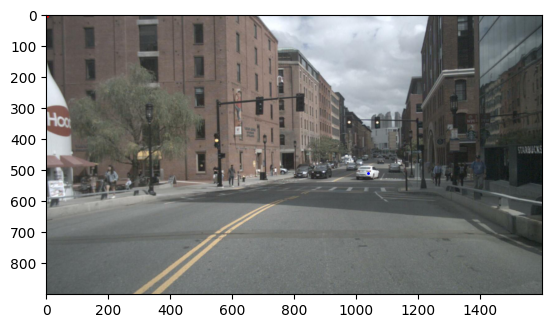

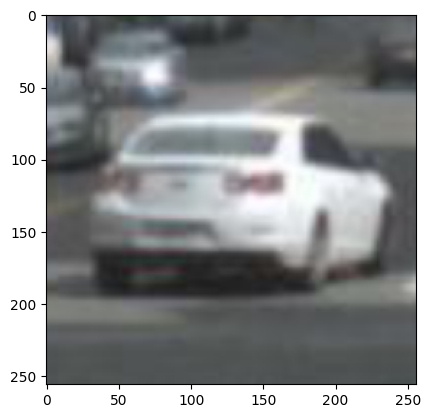

In [7]:
point_screen = nusc_item.point_screen
point_screen = point_screen.squeeze()[:2]
patch_center_2d = nusc_item.patch_center_2d
print("point_screen", point_screen)


# plot on full image on the same figure
def plot_points_on_image(points, fig, ax, color='r'):
    ax.scatter(points[0], points[1], c=color, s=1)
    return fig, ax


full_img = nusc_item.full_img
full_img_np = full_img.numpy().transpose(1, 2, 0)
fig, ax = plt.subplots()
ax.imshow(full_img_np)
plot_points_on_image(point_screen, fig, ax, color='r')
plot_points_on_image(patch_center_2d, fig, ax, color='b')
plt.show()
# plot patch
patch = nusc_item.patch
patch_np = patch.numpy()
patch_np = np.transpose(patch_np, (1, 2, 0))
plt.imshow(patch_np)



In [8]:
nusc_val[5], nusc_val[5].patch_size

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0802, -0.0190,  0.0233]]])
translation tensor([ -0.0802,  -0.0190, -12.8529])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0802, -0.0190,  0.0233]]])
translation tensor([ -0.0802,  -0.0190, -12.8529])


({'sample_idx': 1,
  'cam_idx': 0,
  'cam_name': 'CAM_FRONT',
  'img_path': 'data/nuscenes/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg',
  'cam2img': [[1252.8131021185304, 0.0, 826.588114781398],
   [0.0, 1252.8131021185304, 469.9846626224581],
   [0.0, 0.0, 1.0]],
  'cam2ego': [[0.010260207578539848,
    0.008433448150753975,
    0.9999117851257324,
    1.7220057249069214],
   [-0.9998725652694702,
    0.012316255830228329,
    0.010155927389860153,
    0.004754533059895039],
   [-0.01222951989620924,
    -0.9998885989189148,
    0.008558740839362144,
    1.49491286277771],
   [0.0, 0.0, 0.0, 1.0]],
  'sample_data_token': 'ba01f58b926a472b9d146cb5a54e9a2e',
  'timestamp': 1533151604.012404,
  'lidar2cam': [[0.999883770942688,
    0.012659676373004913,
    -0.008493026718497276,
    9.455266990698874e-05],
   [-0.009169741533696651,
    0.05439155176281929,
    -0.998477578163147,
    -0.35451388359069824],
   [-0.012178453616797924,
    0.9984394311904907,
    0.054

In [9]:
# mark patch_center_2d as red on full image
# idx = 50
import matplotlib.pyplot as plt

for idx in tqdm.tqdm(range(len(nusc_val))):
    full_img = nusc_val[idx].full_img.permute(1,2,0)

    # mark patch_center_2d as red on full image 
    patch_center_2d = nusc_val[idx].patch_center_2d # torch.Size([2])

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 1/486 [00:00<00:55,  8.73it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0368, -0.0075,  0.0136]]])
translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.1017, -0.0248,  0.0222]]])
translation tensor([-0.1017, -0.0248, -9.7796])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0810, -0.0260,  0.0438]]])
translation tensor([-0.0810, -0.0260, -8.9924])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0810, -0.0260,  0.0438]]])
translation tensor([-0.0810, -0.0260, -8.9924])


  1%|          | 4/486 [00:00<00:53,  9.05it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0810, -0.0260,  0.0438]]])
translation tensor([-0.0810, -0.0260, -8.9924])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0810, -0.0260,  0.0438]]])
translation tensor([-0.0810, -0.0260, -8.9924])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0190, -0.0259,  0.0529]]])
translation tensor([-0.0190, -0.0259, -9.9893])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0190, -0.0259,  0.0529]]])
translation tensor([-0.0190, -0.0259, -9.9893])


  1%|          | 5/486 [00:00<00:55,  8.66it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0359, -0.0089,  0.0153]]])
translation tensor([-3.5850e-02, -8.9191e-03, -2.0452e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0177, -0.0211,  0.0158]]])
translation tensor([-0.0177, -0.0211, -8.6526])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0802, -0.0190,  0.0233]]])
translation tensor([ -0.0802,  -0.0190, -12.8529])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0176, -0.0076,  0.0130]]])
translation tensor([-1.7577e-02, -7.5608e-03, -2.1427e+01])


  1%|▏         | 7/486 [00:00<00:58,  8.20it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0359, -0.0089,  0.0153]]])
translation tensor([-3.5850e-02, -8.9191e-03, -2.0452e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0176, -0.0076,  0.0130]]])
translation tensor([-1.7577e-02, -7.5608e-03, -2.1427e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0150, -0.0293,  0.0533]]])
translation tensor([-0.0150, -0.0293, -9.7720])


  2%|▏         | 9/486 [00:01<01:01,  7.73it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0150, -0.0293,  0.0533]]])
translation tensor([-0.0150, -0.0293, -9.7720])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0150, -0.0293,  0.0533]]])
translation tensor([-0.0150, -0.0293, -9.7720])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0150, -0.0293,  0.0533]]])
translation tensor([-0.0150, -0.0293, -9.7720])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0150, -0.0293,  0.0533]]])
translation tensor([-0.0150, -0.0293, -9.7720])


  2%|▏         | 11/486 [00:01<00:59,  7.99it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0384, -0.0150,  0.0309]]])
translation tensor([ -0.0384,  -0.0150, -13.6292])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0735, -0.0193,  0.0239]]])
translation tensor([ -0.0735,  -0.0193, -13.2307])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0114, -0.0417,  0.0315]]])
translation tensor([ 0.0114, -0.0417, -7.6230])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0135, -0.0254,  0.0230]]])
translation tensor([  0.0135,  -0.0254, -10.2239])


  3%|▎         | 13/486 [00:01<01:05,  7.26it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0013, -0.0246,  0.0169]]])
translation tensor([ 1.3418e-03, -2.4632e-02, -8.1804e+00])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0112, -0.0093,  0.0137]]])
translation tensor([-1.1180e-02, -9.2548e-03, -2.0453e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0135, -0.0254,  0.0230]]])
translation tensor([  0.0135,  -0.0254, -10.2239])


  3%|▎         | 14/486 [00:01<01:08,  6.89it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0192, -0.0101,  0.0238]]])
translation tensor([-1.9190e-02, -1.0139e-02, -1.7994e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0192, -0.0101,  0.0238]]])
translation tensor([-1.9190e-02, -1.0139e-02, -1.7994e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0085, -0.0282,  0.0539]]])
translation tensor([-8.4866e-03, -2.8191e-02, -9.7719e+00])


  3%|▎         | 16/486 [00:02<01:05,  7.15it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0192, -0.0101,  0.0238]]])
translation tensor([-1.9190e-02, -1.0139e-02, -1.7994e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0192, -0.0101,  0.0238]]])
translation tensor([-1.9190e-02, -1.0139e-02, -1.7994e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0192, -0.0101,  0.0238]]])
translation tensor([-1.9190e-02, -1.0139e-02, -1.7994e+01])


  3%|▎         | 17/486 [00:02<01:06,  7.05it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0972, -0.0569,  0.0425]]])
translation tensor([ 0.0972, -0.0569, -5.2898])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0033, -0.0056,  0.0146]]])
translation tensor([-3.2982e-03, -5.5508e-03, -1.8748e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0379, -0.0240,  0.0255]]])
translation tensor([ 0.0379, -0.0240, -9.1801])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0272, -0.0097,  0.0206]]])
translation tensor([-2.7170e-02, -9.7251e-03, -1.4512e+01])


  4%|▍         | 19/486 [00:02<01:00,  7.74it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0033, -0.0056,  0.0146]]])
translation tensor([-3.2982e-03, -5.5508e-03, -1.8748e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0033, -0.0056,  0.0146]]])
translation tensor([-3.2982e-03, -5.5508e-03, -1.8748e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0084, -0.0093,  0.0193]]])
translation tensor([-8.3616e-03, -9.2956e-03, -2.3679e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0037, -0.0339,  0.0540]]])
translation tensor([-3.7213e-03, -3.3924e-02, -9.5639e+00])


  4%|▍         | 21/486 [00:02<00:58,  7.92it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0084, -0.0093,  0.0193]]])
translation tensor([-8.3616e-03, -9.2956e-03, -2.3679e+01])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0037, -0.0339,  0.0540]]])
translation tensor([-3.7213e-03, -3.3924e-02, -9.5639e+00])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0037, -0.0339,  0.0540]]])
translation tensor([-3.7213e-03, -3.3924e-02, -9.5639e+00])


  5%|▍         | 22/486 [00:02<01:03,  7.29it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0037, -0.0339,  0.0540]]])
translation tensor([-3.7213e-03, -3.3924e-02, -9.5639e+00])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0553, -0.0077,  0.0196]]])
translation tensor([ 0.0553, -0.0077, -6.9214])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0770, -0.0021,  0.0198]]])
translation tensor([-7.7042e-02, -2.1273e-03, -1.4513e+01])


  5%|▍         | 24/486 [00:03<01:16,  6.07it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.3673, -0.1007,  0.0533]]])
translation tensor([ 0.3673, -0.1007, -2.6598])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.3673, -0.1007,  0.0533]]])
translation tensor([ 0.3673, -0.1007, -2.6598])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.0730, -0.0166,  0.0283]]])
translation tensor([ 0.0730, -0.0166, -7.8911])


  5%|▌         | 25/486 [00:03<01:16,  6.04it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[ 0.3673, -0.1007,  0.0533]]])
translation tensor([ 0.3673, -0.1007, -2.6598])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0023, -0.0369,  0.0534]]])
translation tensor([-2.3434e-03, -3.6888e-02, -9.7720e+00])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0023, -0.0369,  0.0534]]])
translation tensor([-2.3434e-03, -3.6888e-02, -9.7720e+00])


  6%|▌         | 27/486 [00:03<01:20,  5.69it/s]

transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0023, -0.0369,  0.0534]]])
translation tensor([-2.3434e-03, -3.6888e-02, -9.7720e+00])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0023, -0.0369,  0.0534]]])
translation tensor([-2.3434e-03, -3.6888e-02, -9.7720e+00])
transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0023, -0.0369,  0.0534]]])
translation tensor([-2.3434e-03, -3.6888e-02, -9.7720e+00])


  6%|▌         | 28/486 [00:03<01:04,  7.09it/s]


transform_points_patch_ndc points_patch_ndc:  torch.Size([1, 1, 3])
_get_pose_6d_lhw point_patch_ndc tensor([[[-0.0023, -0.0369,  0.0534]]])
translation tensor([-2.3434e-03, -3.6888e-02, -9.7720e+00])
bbox out of bounds of image: x1, x2, y1, y2 -442.53260803222656 41.46739196777344 360 844 img size: (1600, 900)


ValueError: not enough values to unpack (expected 3, got 2)

[autoreload of src.data.datasets.nuscenes failed: Traceback (most recent call last):
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/fs/pci-sharedt/tb21/generative-detection/src/data/datasets/nuscenes.py", line 352, in <module>
    class NuScenesTrain(NuScenesBase):
  File "/n/fs/pci-sharedt/tb21/miniconda3/env

bbox out of bounds of image: x1, x2, y1, y2 -138.08513641357422 9.914863586425781 364 512 img size: (1600, 900)
patch None
patch_size_original None
translation tensor([-0.1017, -0.0248, -9.7796])


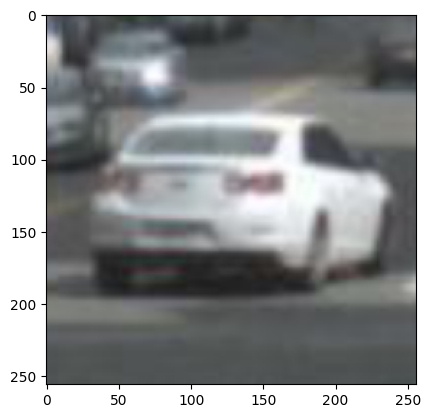

(None, 485)

In [ ]:
patch = nusc_val[idx].patch.permute(1,2,0).numpy()
plt.imshow(patch)
plt.show(), idx

[autoreload of src.data.datasets.nuscenes failed: Traceback (most recent call last):
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/fs/pci-sharedt/tb21/generative-detection/src/data/datasets/nuscenes.py", line 351, in <module>
    class NuScenesTrain(NuScenesBase):
  File "/n/fs/pci-sharedt/tb21/miniconda3/env

translation tensor([  0.0135,  -0.0254, -10.2239])
translation tensor([ -0.0735,  -0.0193, -13.2307])


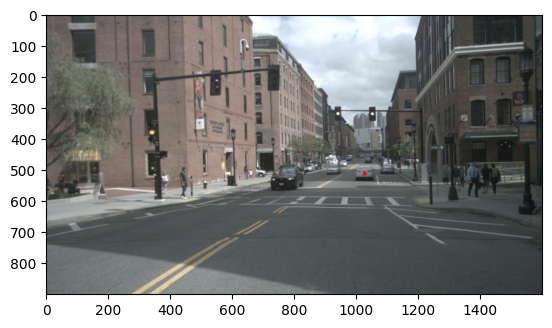

translation tensor([  0.0135,  -0.0254, -10.2239])


(None, tensor([[ -0.0124,  -0.0303, -10.2239,   0.0000,   0.0000,   1.7560]]))

In [ ]:
# mark patch_center_2d as red on full image
idx = 11
import matplotlib.pyplot as plt

full_img = nusc_val[idx].full_img.permute(1,2,0)

# mark patch_center_2d as red on full image 
patch_center_2d = nusc_val[idx].patch_center_2d # torch.Size([2])

full_img = full_img.numpy()
full_img = full_img.copy() # (900, 1600, 3)

# make patch_center_2d as red with surrounding pixels red

patch_center_2d = patch_center_2d.numpy()
patch_center_2d = patch_center_2d.astype(int)
patch_center_2d = patch_center_2d.tolist()

for i in range(-5, 6):
    for j in range(-5, 6):
        full_img[patch_center_2d[1]+i, patch_center_2d[0]+j, :] = [1,0,0]
        
plt.imshow(full_img)
plt.show(), nusc_val[idx].pose_6d

In [ ]:
# visualize 

In [ ]:
nusc_val[0].full_img.shape, nusc_val[0].patch.shape

translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])
translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])


(torch.Size([3, 900, 1600]), torch.Size([3, 256, 256]))

In [ ]:
nusc_val[0].full_img.min(), nusc_val[0].full_img.max()

translation tensor([-0.1017, -0.0248, -9.7796])
translation tensor([-0.1017, -0.0248, -9.7796])


(tensor(0.), tensor(1.))

translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])
translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])


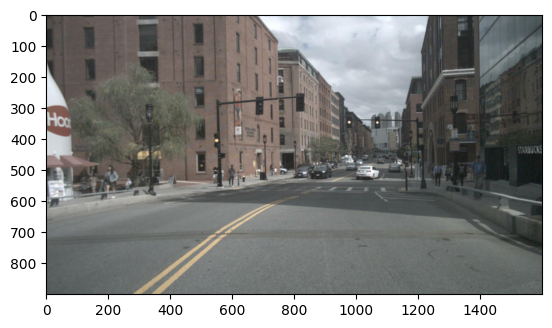

In [ ]:
import matplotlib.pyplot as plt
nusc_val[0].full_img.shape # torch.Size([3, 900, 1600])
plt.imshow(nusc_val[0].full_img.permute(1,2,0))


In [ ]:
nusc_val[0].patch.min(), nusc_val[0].patch.max()

translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])
translation tensor([-0.1017, -0.0248, -9.7796])


[autoreload of src.data.datasets.nuscenes failed: Traceback (most recent call last):
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/n/fs/pci-sharedt/tb21/miniconda3/envs/inrdetect4/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/fs/pci-sharedt/tb21/generative-detection/src/data/datasets/nuscenes.py", line 349, in <module>
    class NuScenesTrain(NuScenesBase):
  File "/n/fs/pci-sharedt/tb21/miniconda3/env

(tensor(0.1333), tensor(1.))

translation tensor([-0.0190, -0.0259, -9.9893])


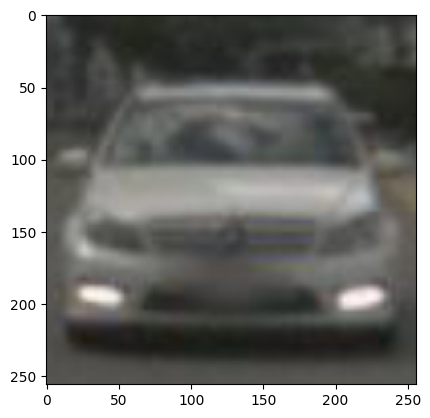

In [ ]:
plt.imshow(nusc_val[1].patch.permute(1,2,0))

translation tensor([-3.6767e-02, -7.4989e-03, -2.2498e+01])


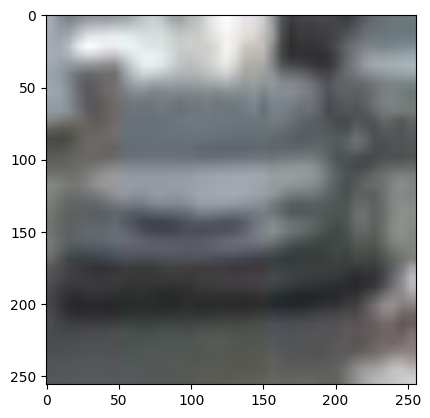

In [ ]:
plt.imshow(nusc_val[0].patch.permute(1,2,0))

In [ ]:
nusc_val[1].patch.min(), nusc_val[1].patch.max()

translation tensor([-0.0810, -0.0260, -8.9924])
translation tensor([-0.0810, -0.0260, -8.9924])


(tensor(0.0588), tensor(0.7451))

In [ ]:
nusc_val[1].patch.max(), nusc_val[1].patch.min()

translation tensor([-0.0190, -0.0259, -9.9893])
translation tensor([-0.0190, -0.0259, -9.9893])


(tensor(1.), tensor(0.0588))